In [39]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter

import re
import string

from sklearn.feature_extraction.text import CountVectorizer

In [40]:
data = pd.read_csv('data/train.csv')

/var/folders/6t/t1pgd71d3296txhmwy6fg76r0000gn/T/ipykernel_64727/2801730928.py:1: DtypeWarning: Columns (112,114,121,125,157,168,186,188,206,208,217,229,231,232,233,235,237,241,244,246,247,249,250,251,268,270,271,280,282,286,288,289,291,305,310,312,313,315,316,318,319,323,324,327,328,329,331,333,335,336,338,342,344,348,350,352,353,355,356,358,359,361) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/train.csv')


In [41]:
data.columns

Index(['id', 'context', 'is_mult_event', 'annotations/0/events/0/event_id',
       'annotations/0/events/0/event_type',
       'annotations/0/events/0/Trigger/text/0/0',
       'annotations/0/events/0/Trigger/start/0/0',
       'annotations/0/events/0/Trigger/entity_id/0',
       'annotations/0/events/0/Treatment/text/0/0',
       'annotations/0/events/0/Treatment/start/0/0',
       ...
       'annotations/0/events/3/Subject/entity_id/0',
       'annotations/0/events/3/Subject/Population/text/0/0',
       'annotations/0/events/3/Subject/Population/start/0/0',
       'annotations/0/events/3/Subject/Population/entity_id/0',
       'annotations/0/events/0/Treatment/Dosage/text/3/0',
       'annotations/0/events/0/Treatment/Dosage/start/3/0',
       'annotations/0/events/0/Treatment/Dosage/entity_id/3',
       'annotations/0/events/0/Treatment/Combination/0/Drug/text/5/0',
       'annotations/0/events/0/Treatment/Combination/0/Drug/start/5/0',
       'annotations/0/events/0/Treatment/Combi

In [42]:
# Select columns to be retained and rename them
selected_columns = ['id', 'context', 'annotations/0/events/0/event_type', 
                    'annotations/0/events/0/Trigger/text/0/0', 
                    'annotations/0/events/0/Treatment/Drug/text/0/0','annotations/0/events/0/Effect/text/0/0']
new_names = ['id', 'context', 'event_type', 'trigger_text', 'drug', 'drug_effect']
df = data[selected_columns].rename(columns=dict(zip(selected_columns, new_names)))

In [43]:
df

,id,context,event_type,trigger_text,drug,drug_effect
0,8908396_3,OBJECTIVE: To test the hypothesis that tumor n...,Adverse_event,induced,insulin,lipoatrophies
1,10891991_1,An evaluation of ovarian structure and functio...,Adverse_event,develop,valproate,menstrual cycle disturbances
2,2332596_1,Phenobarbital hepatotoxicity in an 8-month-old...,Adverse_event,in,Phenobarbital,hepatotoxicity
3,12552054_1,The authors report a case of Balint syndrome w...,Adverse_event,following,methotrexate,Balint syndrome with irreversible posterior le...
4,19531695_12,"According to the Naranjo probability scale, fl...",Adverse_event,cause,flecainide,delirium
...,...,...,...,...,...,...
2893,2931445_3,L-T4 stimulated lymphocyte transformation in t...,Adverse_event,stimulated,L-T4,lymphocyte transformation
2894,12126225_1,A 53-year-old man developed lower leg edema 4 ...,Adverse_event,after,rosiglitazone,lower leg edema
2895,3143551_2,A mentally retarded 23-year-old woman with myo...,Adverse_event,during,valproate,"abnormal posture of extreme forward flexion, c..."
2896,12086549_1,"After 5 days of treatment with IL-2, the patie...",Adverse_event,developed,IL-2,a hemorrhagic lesion that progressed to toxic ...


In [44]:
unique_counts = df['event_type'].value_counts()

# Display the unique values and their counts
print(unique_counts)

Adverse_event                  2650
Potential_therapeutic_event     248
Name: event_type, dtype: int64


In [45]:
# Character counts
df["char_count"] = df["context"].map(lambda x: len(x))
# Word counts
df["word_count"] = df["context"].map(lambda x: len(x.split()))
# Sentence counts
df["sent_count"] = df["context"].map(lambda x: len(sent_tokenize(x)))
# String counts
df["hashtag_count"] = df["context"].map(lambda x: x.count("#"))
# Average word length
df["avg_word_len"] = df["context"].map(lambda x: np.mean([len(w) for w in str(x).split()]))
# Average sentence length
df["avg_sent_len"] = df["context"].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)
    
    return text

df["context_clean"] = df["context"].map(lambda x: clean_text(x))

def get_most_common_words(df):
    stop = set(stopwords.words("english"))

    corpus = [word for i in df["context_clean"].str.split().values.tolist() for word in i if (word not in stop)]
    most_common = Counter(corpus).most_common(10)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)
        
    return words, frequency

def get_ngram_freq(n, df):
    # Initialize CountVectorizer
    vec = CountVectorizer(stop_words = stop, 
                          ngram_range = (n, n))

    # Matrix of ngrams
    bow = vec.fit_transform(df["context_clean"])

    # Count frequency of ngrams
    count_values = bow.toarray().sum(axis=0)

    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame([(count_values[i], k) for k, i in vec.vocabulary_.items()])
    ngram_freq.columns = ["frequency", "ngram"]
    ngram_freq.sort_values(by = "frequency",  ascending = False, inplace = True)

    return ngram_freq

In [28]:
df

,id,context,event_type,trigger_text,drug,drug_effect,char_count,word_count,sent_count,hashtag_count,avg_word_len,avg_sent_len,context_clean
0,8908396_3,OBJECTIVE: To test the hypothesis that tumor n...,Adverse_event,induced,insulin,lipoatrophies,238,33,1,0,6.242424,33.0,objective to test the hypothesis that tumor ne...
1,10891991_1,An evaluation of ovarian structure and functio...,Adverse_event,develop,valproate,menstrual cycle disturbances,214,30,1,0,6.166667,30.0,an evaluation of ovarian structure and functio...
2,2332596_1,Phenobarbital hepatotoxicity in an 8-month-old...,Adverse_event,in,Phenobarbital,hepatotoxicity,54,6,1,0,8.166667,6.0,phenobarbital hepatotoxicity in an 8monthold i...
3,12552054_1,The authors report a case of Balint syndrome w...,Adverse_event,following,methotrexate,Balint syndrome with irreversible posterior le...,150,19,1,0,6.947368,19.0,the authors report a case of balint syndrome w...
4,19531695_12,"According to the Naranjo probability scale, fl...",Adverse_event,cause,flecainide,delirium,237,31,1,0,6.677419,31.0,according to the naranjo probability scale fle...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,2931445_3,L-T4 stimulated lymphocyte transformation in t...,Adverse_event,stimulated,L-T4,lymphocyte transformation,58,7,1,0,7.428571,7.0,lt4 stimulated lymphocyte transformation in th...
2894,12126225_1,A 53-year-old man developed lower leg edema 4 ...,Adverse_event,after,rosiglitazone,lower leg edema,123,21,1,0,4.904762,21.0,a 53yearold man developed lower leg edema 4 we...
2895,3143551_2,A mentally retarded 23-year-old woman with myo...,Adverse_event,during,valproate,"abnormal posture of extreme forward flexion, c...",178,22,1,0,7.136364,22.0,a mentally retarded 23yearold woman with myocl...
2896,12086549_1,"After 5 days of treatment with IL-2, the patie...",Adverse_event,developed,IL-2,a hemorrhagic lesion that progressed to toxic ...,159,25,1,0,5.400000,25.0,after 5 days of treatment with il2 the patient...


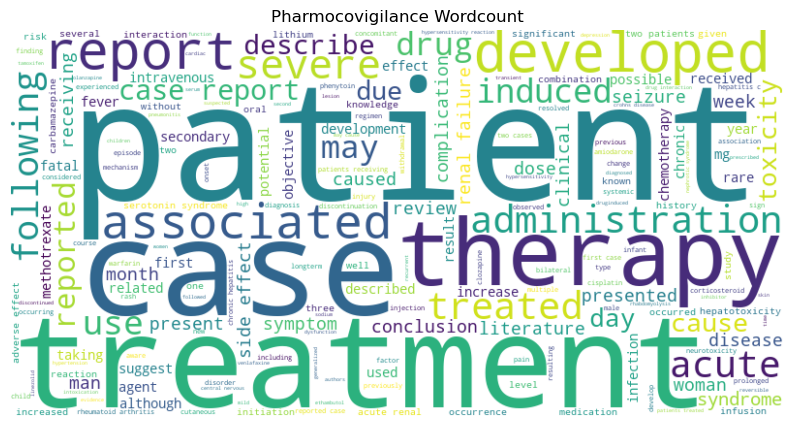

In [47]:
# Concatenate all text data into a single string
text = ' '.join(df['context_clean'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Pharmocovigilance Wordcount')
plt.show()